In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
dataset = pd.read_csv('AB_NYC_2019.csv')
dataset.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
work_columns = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

In [5]:
df = dataset[work_columns]
df.sample(5)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
47116,40.72304,-73.98372,159,1,5,5.00,1,170
21173,40.68687,-73.99471,190,2,15,0.53,1,162
37228,40.74257,-73.97948,355,2,5,0.66,1,230
17768,40.68374,-73.90988,100,4,85,2.41,2,107
45318,40.71801,-73.95244,43,1,2,1.09,1,249


## EDA

In [6]:
df.dtypes

latitude                          float64
longitude                         float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

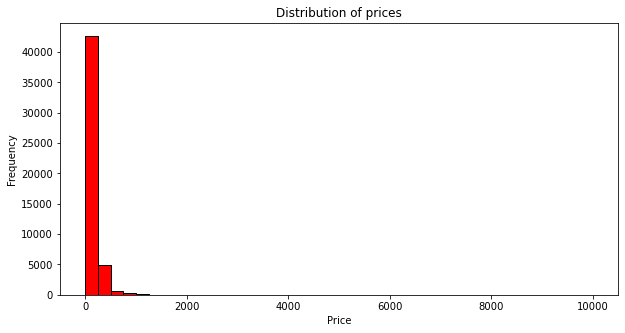

In [7]:
plt.figure(figsize=(10, 5))

sns.histplot(df.price, bins=40, color='red', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

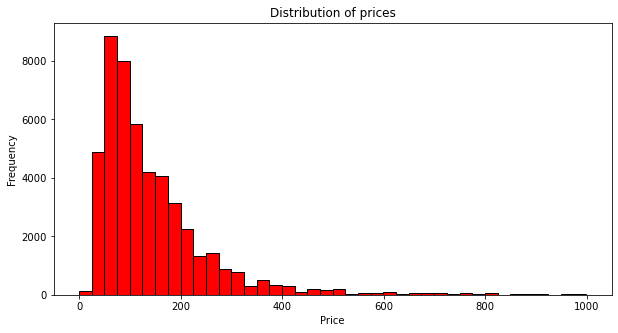

In [8]:
plt.figure(figsize=(10, 5))

sns.histplot(df.price[df.price < 1000], bins=40, color='red', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

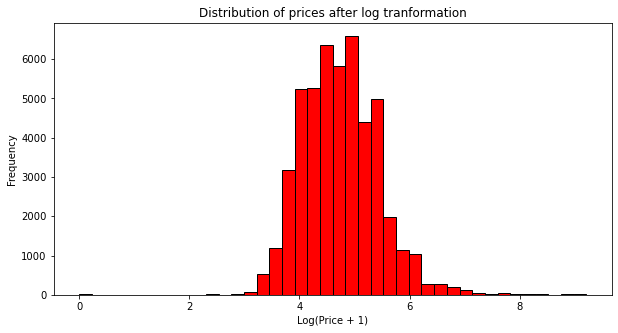

In [9]:
log_price = np.log1p(df.price)

plt.figure(figsize=(10, 5))

sns.histplot(log_price, bins=40, color='red', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

### Question 1: Number of missing values *

Find a feature with missing values. How many missing values does it have?

In [10]:
df.isna().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

### Question 2: Median for minimum_nights *

What's the median (50% percentile) for variable 'minimum_nights'?

In [11]:
df['minimum_nights'].median()

3.0

In [12]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

# split dataset on train, validation and test data
df_train = df_shuffled.iloc[: n_train].copy()
df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val: ].copy()

# transform price
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

# delete price from datasets
del df_train['price']
del df_val['price']
del df_test['price']

## Linear Regression

In [13]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)    
    return w[0], w[1:]


def prepare_X(df, fill_value=0):
    df_num = df.fillna(fill_value)
    X = df_num.values
    return X


def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Question 3: Best way to fill NAs *

<ul>
<li>We need to deal with missing values for the column from Q1.</li>
<li>We have two options: fill it with 0 or with the mean of this variable.</li>
<li>Try both options. For each, train a linear regression model without regularization using the code from the lesssons.</li>
<li>For computing the mean, use the training only!</li>
<li>Use the validation dataset to evaluate the models and compare the RMSE of each option.</li>
<li>Round the RMSE scores to 2 decimal digits using round(score, 2)</li>
<li>Which option gives better RMSE?</li>
</ul>

In [14]:
# fill missing value 0
X_train_fill_0 = prepare_X(df_train, fill_value=0)
w_0_fill_0, w_fill_0 = train_linear_regression(X_train_fill_0, y_train)

X_val_fill_0 = prepare_X(df_val, fill_value=0)
y_pred_fill_0 = w_0_fill_0 + X_val_fill_0.dot(w_fill_0)
print('validation', rmse(y_val, y_pred_fill_0))

validation 0.6430337788649609


In [15]:
# fill missing value mean_value
mean_value = round(df['reviews_per_month'].mean(), 2)
print('mean_value =', mean_value)

X_train_fill_mean = prepare_X(df_train, fill_value=mean_value)
w_0_fill_mean, w_fill_mean = train_linear_regression(X_train_fill_mean, y_train)

X_val_fill_mean = prepare_X(df_val, fill_value=0)
y_pred_fill_mean = w_0_fill_mean + X_val_fill_mean.dot(w_fill_mean)
print('validation', rmse(y_val, y_pred_fill_mean))

mean_value = 1.37
validation 0.6429183734648701


Answer 3: Both are equally good(because the obtained values look very similar)

## Regularization

In [16]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

### Question 4: Best regularization parameter r *

In [17]:
X_train = prepare_X(df_train, fill_value=0)
X_val = prepare_X(df_val, fill_value=0)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred), 5))

     0 0.64303
 1e-06 0.64303
0.0001 0.64307
 0.001 0.64377
  0.01 0.65575
   0.1 0.67733
     1 0.68231
     5 0.68279
    10 0.68284


Answer 4: 0

### Question 5: STD of RMSE scores for different seeds *

<ul>
<li>We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.</li>

<li>Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].</li>
    
<li>For each seed, do the train/validation/test split with 60%/20%/20% distribution.</li>
    
<li>Fill the missing values with 0 and train a model without regularization.</li>
    
<li>For each seed, evaluate the model on the validation dataset and collect the RMSE scores.</li>
    
<li>What's the standard deviation of all the scores? To compute the standard deviation, use np.std.</li>
    
<li>Round the result to 3 decimal digits (round(std, 3))</li>

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.
</ul>

In [18]:
seed_results = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    # split dataset on train, validation and test data
    df_train = df_shuffled.iloc[: n_train].copy()
    df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val: ].copy()

    # transform price
    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)

    # delete price from datasets
    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    X_train = prepare_X(df_train, fill_value=0)
    X_val = prepare_X(df_val, fill_value=0)


    w_0, w = train_linear_regression_reg(X_train, y_train, r=0)
    y_pred = w_0 + X_val.dot(w)
    seed_results.append(rmse(y_val, y_pred))

round(np.std(seed_results), 3)

0.008

Answer 5: 0.008

### Question 6: RMSE on test *

<ul>
<li>Split the dataset like previously, use seed 9.</li>
<li>Combine train and validation datasets.</li>
<li>Train a model with r=0.001.</li>
<li>What's the RMSE on the test dataset?</li>
</ul>

In [19]:

np.random.seed(9)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

# split dataset on train, validation and test data
df_train = df_shuffled.iloc[: n_train].copy()
df_val = df_shuffled.iloc[n_train: n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val: ].copy()

# transform price
y_train = np.log1p(df_train.price)
y_val = np.log1p(df_val.price)
y_test = np.log1p(df_test.price)

# delete price from datasets
del df_train['price']
del df_val['price']
del df_test['price']

# Combine train and validation datasets.
df_train = pd.concat([df_train, df_val])
y_train = pd.concat([y_train, y_val])

X_train = prepare_X(df_train, fill_value=0)
X_test = prepare_X(df_test, fill_value=0)


w_0, w = train_linear_regression_reg(X_test, y_test, r=0.001)
y_pred = w_0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

0.65

Answer 6: 0.65